In [1]:
import os
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from core import aggregate_daily_data
from core import plot_utils

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics

## Create datasets
### Daily data

In [3]:
df_daily = pd.read_csv(os.path.join('.', 'Assessment Data_Daily.csv'))
df_daily = aggregate_daily_data.clean_rows_helper(df_daily)
df_daily = aggregate_daily_data.create_date_columns_helper(df_daily)
df_daily = aggregate_daily_data.one_hot_encode_assessment_helper(df_daily)
df_daily = aggregate_daily_data.subset_data_by_schedule_status_helper(df_daily)
print(f"shape daily data: {df_daily.shape}")
df_daily.head()

shape daily data: (201, 32)


,Assessment Type,Assessment Kick-Off Date,Assessment Schedule Notes,Assessment Schedule Status,Assessor(s),Assessment Documents,Assessment Estimated Completion Date,Assessment in the Next 90 Days?,Assessment Outbrief,Assessment Report Due,...,Year,Month,Day,Date,ATT,LSCA,OA,SCA,TRA,total_assessments_computed
0,OA,10/3/17,NaN,Completed,NaN,NaN,NaN,No,NaN,NaN,...,2017,10,1,2017-10-01,0,0,1,0,0,1
1,SCA,10/16/17,NaN,Completed,NaN,NaN,NaN,No,10/30/17,11/1/17,...,2017,10,1,2017-10-01,0,0,0,1,0,1
2,OA,11/21/17,NaN,Completed,NaN,NaN,NaN,No,NaN,NaN,...,2017,11,1,2017-11-01,0,0,1,0,0,1
3,SCA,12/4/17,NaN,Completed,NaN,NaN,NaN,No,12/18/17,12/20/17,...,2017,12,1,2017-12-01,0,0,0,1,0,1
4,OA,12/19/17,NaN,Completed,NaN,NaN,NaN,No,NaN,NaN,...,2017,12,1,2017-12-01,0,0,1,0,0,1


### ALL Monthly data

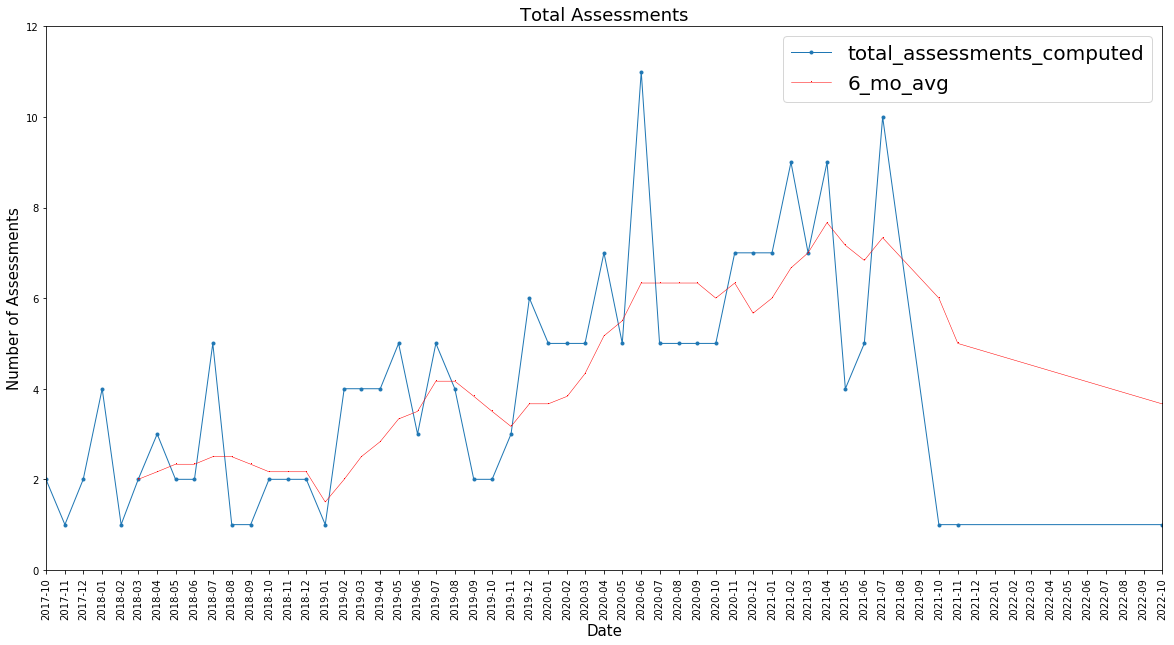

In [4]:
monthly_data = aggregate_daily_data.create_monthly_aggregate_from_daily_data_helper(df_daily)
plt.figure(figsize=(20,10))
ax = monthly_data['total_assessments_computed'].plot(marker = '.', linewidth=1)
MOVING_AVG_WINDOW = 6
monthly_data['6_mo_avg'] = (monthly_data['total_assessments_computed'].
                              rolling(window=MOVING_AVG_WINDOW).mean())
ax2 = monthly_data['6_mo_avg'].plot(marker = ",", linewidth=0.5, color = "red")
plt.ylabel('Number of Assessments', size=15)
plt.xlabel("Date", size=15)
plt.title('Total Assessments', size=18)
plt.xticks(rotation=90)
ax.set_ylim([0, 12])
ax.set_xlim([min(monthly_data.index), max(monthly_data.index)])
plt.legend(fontsize=20)
# Major ticks every month.
formatter = mdates.DateFormatter("%Y-%m") ### formatter of the date
locator = mdates.MonthLocator()
ax.xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
ax.xaxis.set_major_locator(locator)

## Current lr model

In [5]:
monthly_data['time_index'] = np.arange(len(monthly_data))
monthly_data.head()

,ATT,LSCA,OA,SCA,TRA,total_assessments_computed,6_mo_avg,time_index
Date,,,,,,,,
2017-10-01,0,0,1,1,0,2,NaN,0
2017-11-01,0,0,1,0,0,1,NaN,1
2017-12-01,0,0,1,1,0,2,NaN,2
2018-01-01,0,0,3,1,0,4,NaN,3
2018-02-01,0,0,0,1,0,1,NaN,4


In [6]:
X = monthly_data.time_index.values
y = (monthly_data['total_assessments_computed']).values
X = X.reshape(-1,1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
reg_all = linear_model.LinearRegression()
reg_all.fit(X_train, y_train)
print('-------------------------------------------')
from sklearn import metrics 
print('Root Mean Squared Error-Test:', np.sqrt(metrics.mean_squared_error(y_test, reg_all.predict(X_test))))
mse = metrics.mean_squared_error(y_test, reg_all.predict(X_test))
print('Mean Squared Error-Test:',mse)

-------------------------------------------
Root Mean Squared Error-Test: 1.9892596747443818
Mean Squared Error-Test: 3.9571540535641234


In [8]:
Xnew = [X.max() + increment for increment in range(1,6)]
Xnew

[49, 50, 51, 52, 53]

In [9]:
ynew = reg_all.predict(X)
for i in range(len(Xnew)):
    print("X=%s, Predicted=%s" % (Xnew[i], ynew[i]))

X=49, Predicted=1.7067635824983114
X=50, Predicted=1.8078233123339478
X=51, Predicted=1.9088830421695842
X=52, Predicted=2.0099427720052203
X=53, Predicted=2.111002501840857


## Monthly Prediction
#### At the end of every month predict the next three months